In [21]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d 

## To do
- make sure that the displacement does not exit L
- implement the montecarlo step as runnning trhough every single bead

In [22]:
# load data calcualted from the previous part
wa = np.loadtxt('w_a.csv', delimiter=',')
wb = np.loadtxt('w_b.csv', delimiter=',')

# set up a seed to repeat experiments
np.random.RandomState(seed=111)

RandomState(MT19937) at 0x7FE5BFAE16B0

In [23]:
# ----------------------
# Global Constants------
# ----------------------
Re = 1.0
# number of points in space 
Nx = 256
# number of beads in the polymer contour
N = 64
# polymer contour
S = np.linspace(0,1,N)
# cutting point of the polymer diving A and B
F = 1/2
L = 2*1.0
X = np.linspace(0,Nx, Nx)
X = X*L/Nx


**Steps to take**

1. generate some distribution of random positions for the beads
2. choose a random bead
3. move a this bead a random displacement $\Delta$ in all 3 coordinates, $\Delta$ has to be able to be positive or negative
4. Accept or reject the move according to the metropolis criterion
5. repeat until every single bead in the chain is moved
6. this is one montecarlo step. Repeat many times reach equilibrium

**remember**
- only start to take meassurements after the chain has reached equilibrium
- each bead has to be chosen with a uniform distribution
- the favorable step in the metropolis criterion is the one with lower energy.
- experiment with many $\deltas$ to find the optimal one.
- remember to interpolate the field to calculate their value at intermediate x's
- the fields are constant in y and z

In [53]:
# choose and move one bead of the chain
def move_bead(current_chain,d_interval):
    # selects a bead at random and moves it
    # args-> current_chain: array, contains the positions of the current chain
    #        d_interval: displacement interval
    # returns-> proposed_move: array, chain with one displaced bead
    #           bead_index: index indicating which bead was moved
    Delta = np.random.uniform(low=-d_interval,high=d_interval)

    # chose the bead
    proposed_move = current_chain.copy()
    bead_index = np.random.randint(0,N)
    proposed_move[bead_index,:] = proposed_move[bead_index,:] + Delta
    
    return proposed_move, bead_index

def calculate_energy(bead_chain, no_fields=False):
    # calculates the energy for a given chain
    # args -> bead_chain: array, represents the chain to calculate the energy, includes position for each bead
    #        no_fields: boolean, indicates whether we set the fields to zero or not
    # returns- > U: scalar, the enery of bead_chain
    
    s1 = []
    swa = []
    swb = []
    
    for i in range(1, len(bead_chain)):
        # first term in U
        s1_mag = bead_chain[i,:] - bead_chain[i-1,:]
        s1.append(np.dot(s1_mag,s1_mag))
        # terms dependent on w remember only the x value is important
        swa_mag = float(wa_int(bead_chain[i,0]))
        swa.append(swa_mag)

        swb_mag = float(wb_int(bead_chain[i,0]))
        swb.append(swb_mag)
        
    mask_wa = np.zeros(len(swa))
    mask_wb = np.zeros(len(swb))
    
    if no_fields == False:
        # mask wa and wb such that they  act only on their respective sectors of the chain
        mask_wa[:int(F*N)] = 1
        mask_wb[int(F*N):] = 1
        
    
    U = 3*(N-1)/(2*Re**2) * np.sum(s1) + (1/N)*np.dot(mask_wa,swa) + (1/N)*np.dot(mask_wb,swb)
    
    return U, swa, swb, s1

def metropolis_step(d_u):

SyntaxError: unexpected EOF while parsing (<ipython-input-53-51e2ab561f2a>, line 51)

### Generating the initial chain
make a list of tuples where each element is the position of each bead in the chain

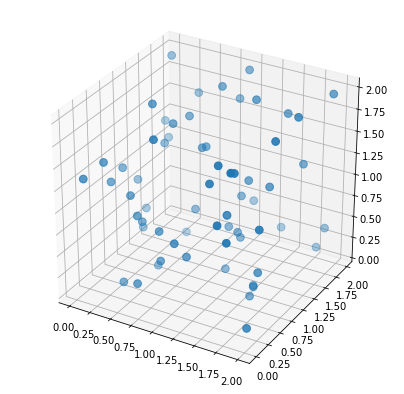

In [25]:
# the chain lives in a box with sides L
# generate the positions of ech of the N beads in s
# rows are the beads, columns the positions of each bead
# xi =  [i,0], yi =  [i,1], zi =  [i,2]
initial_chain = np.random.rand(N,3) * L

# plot them 
plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')
ax.scatter3D(initial_chain[:,0], initial_chain[:,1], initial_chain[:,2], s=60);


In [52]:
# for now choose this as place holder value
d = X[1]-X[0]    
current_chain = initial_chain.copy()
# interpolation of the fields
wa_int = interp1d(X,wa, kind='linear')
wb_int = interp1d(X,wb, kind='linear')

delta_u_list = []

N_moves = 100
acceptance_list = np.zeros(N_moves)

for i in range(0,N_moves):
    next_chain, bead_i = move_bead(current_chain,d)

    # calculate initial and final energies
    u0,sumwa0, sumwb0, sum0 = calculate_energy(current_chain)
    uf,sumwaf, sumwbf, sumf = calculate_energy(next_chain)

    # metropolis step with beta set to one
    delta_u = uf-u0
    delta_u_list.append(delta_u)
    #if negative change we accept
    if(delta_u < 0):
        current_chain = next_chain.copy()
        acceptance_list[i] = 1

    else:
        # draw a random number
        coin_toss = np.random.uniform(0,1)
        dist_delta = np.exp(-delta_u)

        if(coin_toss<dist_delta):
            current_chain = next_chain.copy()
            acceptance_list[i] = 1
        

In [50]:
# move every single bead in the chain and this is one step
acceptance_list

array([1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0.,
       1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
       1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
       1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0.])